Preparing data for deep learning models.

In [212]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%run nnn/ipynb_init.py
import explore_fig as ef

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 432x288 with 0 Axes>

86.43% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
78.88% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
64.31% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
71.46% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
86.43% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
78.88% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
64.31% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
71.46% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5


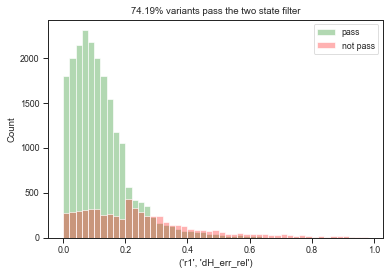

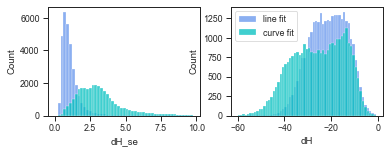

In [215]:
annotation_file = './data/annotation/NNNlib2b_annotation_20220519.tsv'
annotation = fileio.read_annotation(annotation_file, sodium=0.083)
replicate_df = pd.read_table('./data/nnnlib2b_replicates.tsv')

arraydata = ArrayData(replicate_df=replicate_df.iloc[:4,:],
                    annotation_file=annotation_file)

myfilter = "dH_err_rel < 0.2 & Tm_err_abs < 2 & redchi < 1.5 & n_inlier > 10"
pass_df = arraydata.filter_two_state(min_rep_pass=2, force_recalculate=True, overwrite_dH=False, 
                                     inplace=True, myfilter=myfilter)

variant_filter = 'Tm < 55 & Tm > 25'
arr = arraydata.data.join(arraydata.annotation).query(variant_filter)
arraydata.accounting_df.loc['Tm_in_range', :] = arr.groupby('Series').apply(len)
arr['scaffold'] =arr.apply(lambda row: f'{row.bottomScaffold}_{row.topScaffold}', axis=1)

<AxesSubplot:xlabel='Number of variant', ylabel='Series'>

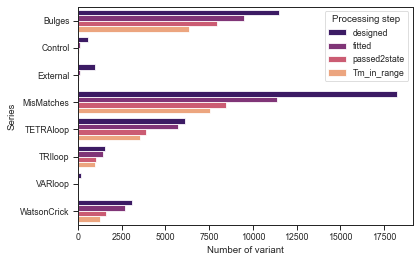

In [216]:
df = arraydata.accounting_df.stack().to_frame('Number of variant').reset_index()
df.rename(columns={'level_0':'Processing step', 'level_1':'Series'}, inplace=True)
sns.barplot(data=df, y='Series', x='Number of variant', hue='Processing step', palette='magma')

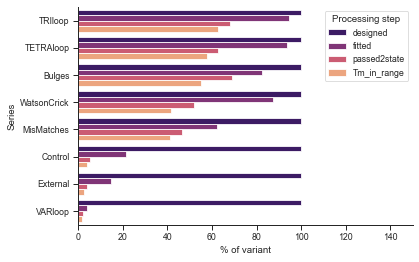

In [217]:
accounting_norm_df = arraydata.accounting_df / arraydata.accounting_df.loc['designed', :] * 100
accounting_norm_df.sort_values(axis=1, by='Tm_in_range', inplace=True, ascending=False)
df = accounting_norm_df.stack().to_frame('% of variant').reset_index()
df.rename(columns={'level_0':'Processing step', 'level_1':'Series'}, inplace=True)
sns.barplot(data=df, y='Series', x='% of variant', hue='Processing step', palette='magma')
plt.xlim([0,150])
sns.despine()

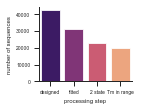

In [238]:
fig, ax = plt.subplots(figsize=(4.25*cm, 3.5*cm))
sns.barplot(data=arraydata.accounting_df.sum(axis=1).reset_index(), x='index', y=0, 
            palette='magma')
plt.ylabel('number of sequences', size=label_font_size)
plt.xlabel('processing step', size=label_font_size)
ax.set_xticklabels(['designed', 'fitted', '2 state', 'Tm in range'])
ax.tick_params(axis='both', which='major', labelsize=tick_font_size)
sns.despine()
util.save_fig('./fig/accounting/processing_steps.pdf')

In [259]:
np.unique(arr.ConstructType.dropna())

array(['3mer', 'AC_mismatch_varpos', 'BaeControls', 'Centered',
       'GT_mismatch_varpos', 'NN', 'NNN', 'NNN_3primebulge',
       'NNN_5prime_bulge', 'NN_3primebulge', 'NN_5primebulge',
       'PUMcontrols', 'VARloop', 'WC_5ntstem', 'WC_6ntstem', 'WC_7ntstem'],
      dtype=object)

In [274]:
excluded_construct_type = ['pseudoknot_pt_muts', 'PolyNTControls', 'RepeatControls', 'StemDangle_3p', 'StemDangle_53p', 'StemDangle_5p', 'PUMcontrols']
arr = arr[arr.reset_index().ConstructType.apply(lambda s: s not in excluded_construct_type).values]
arr = arr.dropna(subset=['ConstructType'])
arr.to_csv('./data/models/arr_clean_220818.csv')

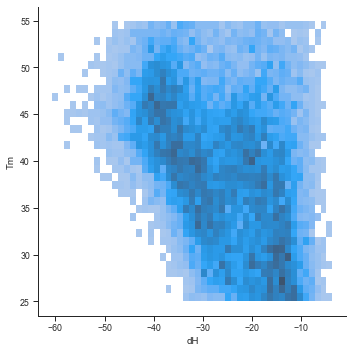

In [249]:
sns.displot(data=arr, x='dH', y='Tm')
# plt.xscale('symlog')TargetStruct

In [284]:
from sklearn.model_selection import train_test_split

train_val_ind, test_ind = train_test_split(arr.index, test_size=.2,
                                       random_state=42, stratify=arr.Series)
train_ind, val_ind = train_test_split(arr.loc[train_val_ind,:].index, test_size=.2,
                                      random_state=43, stratify=arr.loc[train_val_ind,:].Series)
n_train, n_val, n_test = len(train_ind), len(val_ind), len(test_ind)
print(n_train, n_val, n_test)

split_dict = dict(train_ind=train_ind.tolist(),
                  val_ind=val_ind.tolist(),
                  test_ind=test_ind.tolist())
with open('./data/models/train_val_test_split.json', 'w') as fh:
    json.dump(split_dict, fh, indent=4)

12604 3152 3940


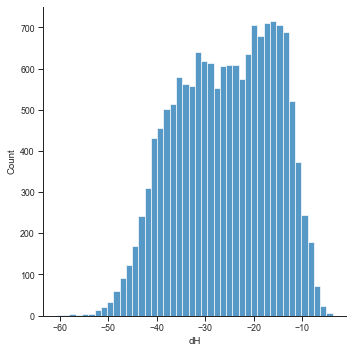

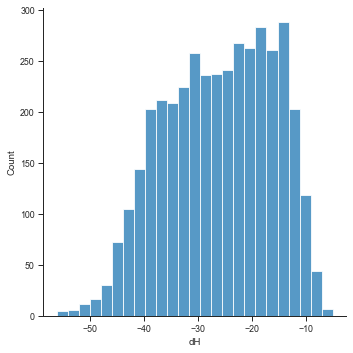

In [257]:
sns.displot(data=arr.loc[train_ind,:], x='dH')
sns.displot(data=arr.loc[test_ind,:], x='dH')

In [73]:
np.random.seed(99)
train_ind_sample = np.random.choice(train_ind, 1500, replace=False)
test_ind_sample = np.random.choice(test_ind, 500, replace=False)

In [36]:
from sklearn.neighbors import KNeighborsRegressor
from Levenshtein import *
from tqdm import tqdm

In [74]:
train_distance = np.zeros((n_train, n_train))
test_distance = np.zeros((n_test, n_train))

for i,seq_i in tqdm(enumerate(arr.loc[train_ind_sample].RefSeq)):
    for j in range(i):
        seq_j = arr.loc[train_ind_sample].iloc[j,:].RefSeq
        train_distance[i,j] = distance(seq_i, seq_j)

1500it [13:35,  1.84it/s]


In [84]:
# test_distance_sample = np.zeros((500, 1500))
for i,seq_i in tqdm(enumerate(arr.loc[test_ind_sample].RefSeq)):
    for j in range(i, 1500):
        seq_j = arr.loc[train_ind_sample].iloc[j,:].RefSeq
        test_distance_sample[i,j] = distance(seq_i, seq_j)

500it [07:38,  1.09it/s]


In [90]:
# train_distance_sample = train_distance[:1500, :1500]
np.save('./data/models/knn/train_distance_sample.npy', train_distance_sample)


In [82]:
np.save('./data/models/knn/test_distance_sample.npy', test_distance_sample)


In [189]:
neigh = KNeighborsRegressor(n_neighbors=15, metric='precomputed', weights='distance')
y = arr.loc[train_ind_sample, ['dH', 'Tm']]
neigh.fit(train_distance_sample, y)
y_pred_test = neigh.predict(test_distance_sample)


In [190]:
y_test = arr.loc[test_ind_sample, ['dH', 'Tm']]
# test_df = pd.concat((y_test, pd.DataFrame(y_pred_test, columns=['dH_pred', 'Tm_pred'])), axis=1, ignore_index=True)
test_df = pd.DataFrame(data=np.concatenate((y_test.values, y_pred_test), axis=1),
                       index=y_test.index,
                       columns=['dH', 'Tm', 'dH_pred', 'Tm_pred'])

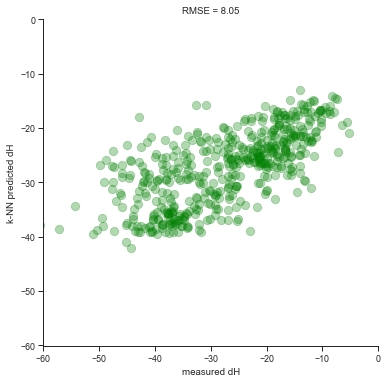

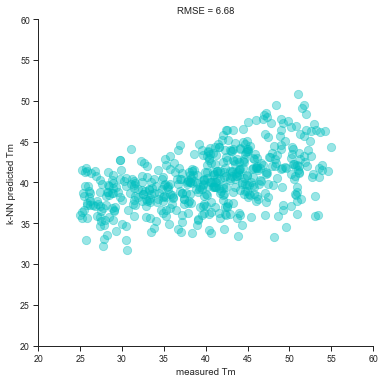

In [197]:
fig, ax = plt.subplots(figsize=(6,6))
plt.scatter(y_test.iloc[:,0], y_pred_test[:,0], 
            s=70, c='g', alpha=0.3)
ax.set_ylim([-60, 0])
ax.set_xlim([-60, 0])
ax.set_xlabel('measured dH')
ax.set_ylabel('k-NN predicted dH')
rmse = np.sqrt(np.sum((y_test.iloc[:,0] - y_pred_test[:,0])**2) / 500)
ax.set_title('RMSE = %.2f' % rmse)
sns.despine()
util.save_fig('./fig/models/knn/dH_15neigh_sample_test.pdf')

fig, ax = plt.subplots(figsize=(6,6))
plt.scatter(y_test.iloc[:,1], y_pred_test[:,1], 
            s=70, c='c', alpha=0.4)
ax.set_ylim([20, 60])
ax.set_xlim([20, 60])
ax.set_xlabel('measured Tm')
ax.set_ylabel('k-NN predicted Tm')
rmse = np.sqrt(np.sum((y_test.iloc[:,1] - y_pred_test[:,1])**2) / 500)
ax.set_title('RMSE = %.2f' % rmse)
sns.despine()
util.save_fig('./fig/models/knn/Tm_15neigh_sample_test.pdf')

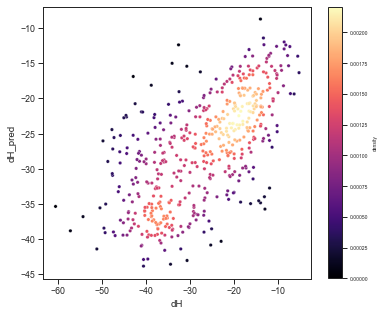

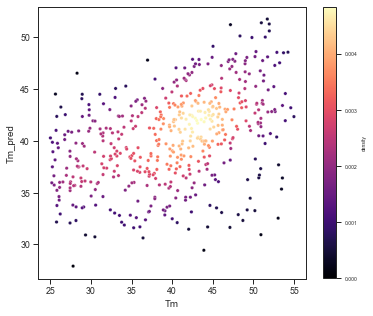

In [116]:
plotting.plot_colored_scatter_comparison(data=test_df, x='dH', y='dH_pred', palette='magma')
plotting.plot_colored_scatter_comparison(data=test_df, x='Tm', y='Tm_pred', palette='magma')

In [89]:
train_distance_sample = train_distance_sample + train_distance_sample.T - np.diag(np.diag(train_distance_sample))


In [278]:
split_dict = dict(train_ind=train_ind.tolist(),
                  val_ind=val_ind.tolist(),
                  test_ind=test_ind.tolist())

In [279]:
with open('./data/models/train_test_split.json', 'w') as fh:
    json.dump(split_dict, fh, indent=4)

In [280]:
with open('./data/models/train_test_split.json', 'r') as fh:
    a = json.load(fh)